In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

kappa_array shape: (25, 800)
l1 sim shape: (25, 800)


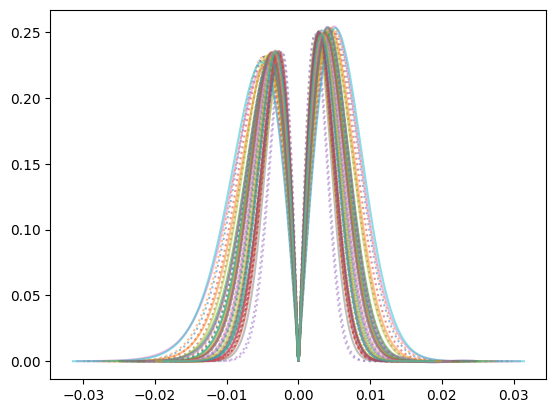

In [2]:
data_path_withoutsim = "../data/filtertophat_results_15_tomobin5_simulationFalse.npy"
data_path_withsim = "../data/filtertophat_results_15_tomobin5_simulationTrue.npy"
# # Load the data
# data_withsim = np.load(data_path_withsim, allow_pickle=True)
# data_withoutsim = np.load(data_path_withoutsim, allow_pickle=True)

data = np.load(data_path_withsim, allow_pickle=True).item()  # Unwrap the dictionary

Om_array = []
sig8_array = []
h_array = []
w_array = []
sigma_sq_array = []
l1_array = []
snr_array = []
l1_sim_array = []
# kappas_vals = np.linspace(-0.04,0.04,401)
for idx, entry in data.items():
    cosmo = entry['cosmology']
    sigma_sq = entry['perturbation_theory_sigma_sq']  # float or scalar
    l1s = np.asarray(entry['prediction_l1'])         # shape: (M,)
    snrs = np.asarray(entry['snr'])                  # shape: (M,)
    om = cosmo['Om']
    sig8 = cosmo['sigma8']
    h = cosmo['h']
    w = cosmo['w']
    l1_sim = np.mean(entry['sim_l1_runs'],axis=0)  # shape: (M,n)
    sigma_sq_array.append(sigma_sq)
    l1_array.append(l1s)
    l1_sim_array.append(l1_sim)
    snr_array.append(snrs)
    Om_array.append(om)
    sig8_array.append(sig8)
    h_array.append(h)
    w_array.append(w)
    
# Convert lists to numpy arrays
Om_array = np.array(Om_array)
sig8_array = np.array(sig8_array)
h_array = np.array(h_array)
w_array = np.array(w_array)
sigma_sq_array = np.array(sigma_sq_array)
l1_array = np.array(l1_array)
l1_sim_array = np.array(l1_sim_array)
snr_array = np.array(snr_array)
kappa_array = snr_array * np.sqrt(sigma_sq_array[:, np.newaxis])
print("kappa_array shape:", kappa_array.shape)
print('l1 sim shape:', l1_sim_array.shape)


data_test = np.load(data_path_withoutsim, allow_pickle=True).item()  # Unwrap the dictionary

Om_array_test = []
sig8_array_test = []
h_array_test = []
w_array_test = []
sigma_sq_array_test = []
l1_array_test = []
snr_array_test = []

# kappas_vals = np.linspace(-0.04,0.04,401)
for idx, entry in data_test.items():
    cosmo = entry['cosmology']
    sigma_sq = entry['perturbation_theory_sigma_sq']  # float or scalar
    l1s = np.asarray(entry['prediction_l1'])         # shape: (M,)
    snrs = np.asarray(entry['snr'])                  # shape: (M,)
    om = cosmo['Om']
    sig8 = cosmo['sigma8']
    h = cosmo['h']
    w = cosmo['w']
    sigma_sq_array_test.append(sigma_sq)
    l1_array_test.append(l1s)
    snr_array_test.append(snrs)
    Om_array_test.append(om)
    sig8_array_test.append(sig8)
    h_array_test.append(h)
    w_array_test.append(w)
    
# Convert lists to numpy arrays
Om_array_test = np.array(Om_array_test)
sig8_array_test = np.array(sig8_array_test)
h_array_test = np.array(h_array_test)
w_array_test = np.array(w_array_test)
sigma_sq_array_test = np.array(sigma_sq_array_test)
l1_array_test = np.array(l1_array_test)
snr_array_test = np.array(snr_array_test)
kappa_array_test = snr_array_test * np.sqrt(sigma_sq_array_test[:, np.newaxis])
plt.figure()
plt.plot(kappa_array_test.T, l1_array_test.T, alpha=0.5, ls=":")
plt.plot(kappa_array.T, l1_array.T, alpha=0.5)
plt.show()



In [8]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import gpytorch
import matplotlib.pyplot as plt
from typing import Optional, Tuple


def flatten_cosmo_data(
    Om_array: np.ndarray,
    sig8_array: np.ndarray,
    h_array: np.ndarray,
    w_array: np.ndarray,
    feature_array: np.ndarray,
    target_array: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Flatten a grid of cosmological parameters and a corresponding feature into a 2D design matrix,
    and flatten the targets.

    Args:
        Om_array, sig8_array, h_array, w_array: 1D arrays of length C (cosmologies).
        feature_array: 2D array of shape (C, M) for the sample feature (e.g., kappa or SNR).
        target_array: 2D array of shape (C, M) with simulation targets.

    Returns:
        X_np: 2D array of shape (C*M, 5) with columns [Om, sig8, h, w, feature].
        y_np: 1D array of length C*M with flattened targets.
    """
    C, M = feature_array.shape
    cosmo = np.stack([Om_array, sig8_array, h_array, w_array], axis=1)
    cosmo_tiled = np.repeat(cosmo, M, axis=0)
    feature_flat = feature_array.reshape(-1, 1)
    y_flat = target_array.reshape(-1)
    X_np = np.hstack([cosmo_tiled, feature_flat])
    return X_np, y_flat


def prepare_data(
    X_np: np.ndarray,
    y_np: np.ndarray,
    batch_size: int = 1024,
    device: Optional[torch.device] = None
) -> Tuple[DataLoader, torch.Tensor, torch.Tensor]:
    """
    Standardize inputs and create a DataLoader for training.

    Returns:
        loader: DataLoader of (X_norm, y).
        X_mean: feature-wise mean tensor.
        X_std: feature-wise std tensor.
    """
    X = torch.from_numpy(X_np).float()
    y = torch.from_numpy(y_np).float()
    X_mean = X.mean(dim=0)
    X_std = X.std(dim=0)
    X_norm = (X - X_mean) / X_std
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_norm = X_norm.to(device)
    y = y.to(device)
    loader = DataLoader(TensorDataset(X_norm, y), batch_size=batch_size, shuffle=True)
    return loader, X_mean.to(device), X_std.to(device)


class VariationalGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points: torch.Tensor, nu: float = 2.5):
        variational_dist = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strat = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_dist,
            learn_inducing_locations=True
        )
        super().__init__(variational_strat)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=nu, ard_num_dims=inducing_points.size(1))
        )

    def forward(self, x: torch.Tensor) -> gpytorch.distributions.MultivariateNormal:
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def build_svgp(
    input_dim: int,
    num_inducing: int = 500,
    X_norm: Optional[torch.Tensor] = None,
    device: Optional[torch.device] = None,
    nu: float = 2.5
) -> Tuple[VariationalGP, gpytorch.likelihoods.GaussianLikelihood]:
    """
    Instantiate a sparse variational GP and Gaussian likelihood.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    assert X_norm is not None, "Provide normalized data to choose inducing points."
    idx = torch.randperm(X_norm.size(0))[:num_inducing]
    inducing_pts = X_norm[idx].clone().to(device)
    model = VariationalGP(inducing_pts, nu=nu).to(device)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    return model, likelihood


def train_svgp(
    model: gpytorch.models.ApproximateGP,
    likelihood: gpytorch.likelihoods.GaussianLikelihood,
    train_loader: DataLoader,
    lr: float = 0.01,
    num_epochs: int = 80,
    cg_tolerance: float = 1e-2,
    max_preconditioner_size: int = 5,
    print_every: int = 10
) -> Tuple[gpytorch.models.ApproximateGP, gpytorch.likelihoods.GaussianLikelihood]:
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=lr)
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(train_loader.dataset))
    for epoch in range(1, num_epochs+1):
        total_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            with gpytorch.settings.fast_pred_var(), \
                 gpytorch.settings.cg_tolerance(cg_tolerance), \
                 gpytorch.settings.max_preconditioner_size(max_preconditioner_size):
                output = model(X_batch)
                loss = -mll(output, y_batch)
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        if epoch % print_every == 0:
            print(f"Epoch {epoch}/{num_epochs}, Avg Loss: {avg_loss:.4f}")
    model.eval()
    likelihood.eval()
    return model, likelihood


def predict_svgp(
    model: gpytorch.models.ApproximateGP,
    likelihood: gpytorch.likelihoods.GaussianLikelihood,
    X_np: np.ndarray,
    X_mean: torch.Tensor,
    X_std: torch.Tensor,
    device: Optional[torch.device] = None
) -> Tuple[torch.Tensor, torch.Tensor]:
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X = torch.from_numpy(X_np).float()
    X_norm = ((X - X_mean.cpu()) / X_std.cpu()).to(device)
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(X_norm))
        return preds.mean.cpu(), preds.variance.cpu()


def plot_cosmology_prediction(
    model: gpytorch.models.ApproximateGP,
    likelihood: gpytorch.likelihoods.GaussianLikelihood,
    Om_array: np.ndarray,
    sig8_array: np.ndarray,
    h_array: np.ndarray,
    w_array: np.ndarray,
    feature_array: np.ndarray,
    target_array: np.ndarray,
    X_mean: torch.Tensor,
    X_std: torch.Tensor,
    idx: int,
    device: Optional[torch.device] = None,
    title_prefix: str = "Cosmology"
) -> plt.Figure:
    """
    Plot training (or test) data and GP predictions with 95% CI for a given cosmology index.
    """
    feature_vals = feature_array[idx]
    target_vals = target_array[idx]
    print(f"{title_prefix} #{idx}: (Om={Om_array[idx]}, sig8={sig8_array[idx]}, h={h_array[idx]}, w={w_array[idx]})")
    M = feature_vals.shape[0]
    cosmo_params = np.array([Om_array[idx], sig8_array[idx], h_array[idx], w_array[idx]])
    X_cosmo = np.hstack([
        np.repeat(cosmo_params.reshape(1, -1), M, axis=0),
        feature_vals.reshape(-1, 1)
    ])
    mu, var = predict_svgp(model, likelihood, X_cosmo, X_mean, X_std, device)
    std = torch.sqrt(var).numpy()
    mu = mu.numpy()
    fig = plt.figure()
    plt.plot(feature_vals, target_vals, 'o', label='True $L_1$')
    plt.plot(feature_vals, mu, '-', label='Predicted mean')
    plt.fill_between(feature_vals, mu - 1.96*std, mu + 1.96*std, alpha=0.2, label='95% CI')
    plt.xlabel('Feature')
    plt.ylabel('Target')
    plt.legend()
    plt.title(f"{title_prefix} #{idx}")
    return fig


Epoch 10/80, Avg Loss: -0.1695
Epoch 20/80, Avg Loss: -1.1385
Epoch 30/80, Avg Loss: -1.7651
Epoch 40/80, Avg Loss: -2.4217
Epoch 50/80, Avg Loss: -2.7204
Epoch 60/80, Avg Loss: -2.8323
Epoch 70/80, Avg Loss: -2.8804
Epoch 80/80, Avg Loss: -2.9020
Cosmology #2: (Om=0.2536, sig8=0.667, h=0.6238, w=-1.7698)
Test Cosmology #5: (Om=0.229786, sig8=0.814115, h=0.718291, w=-0.769299)


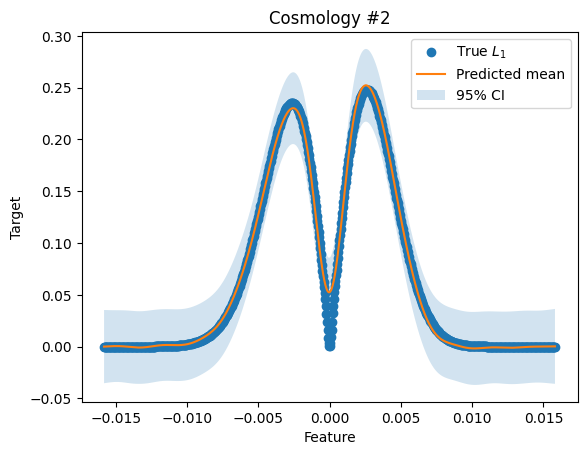

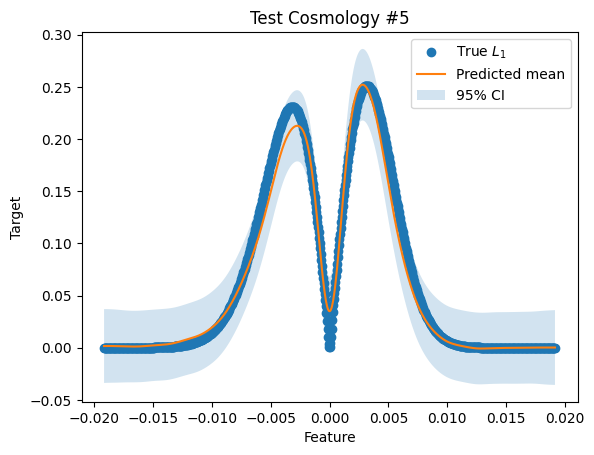

In [10]:

# flatten into (C*M, 5) inputs and (C*M,) targets
C, M = snr_array.shape

# stack cosmology parameters, then tile snr
cosmo = np.stack([Om_array, sig8_array, h_array, w_array], axis=1)   # (C,4)
cosmo_tiled = np.repeat(cosmo, M, axis=0)                             # (C*M,4)
snr_flat   = kappa_array.reshape(-1, 1)                                 # (C*M,1)
X_np       = np.hstack([cosmo_tiled, snr_flat])                       # (C*M,5)
y_np       = l1_sim_array.reshape(-1)                                     # (C*M,)



# Flatten raw arrays into X_np, y_np
X_np, y_np = flatten_cosmo_data(
    Om_array, sig8_array, h_array, w_array,
    kappa_array, l1_sim_array
)

# Prepare loader
train_loader, X_mean, X_std = prepare_data(X_np, y_np)

# Build, train, predict as before…
model, likelihood = build_svgp(input_dim=5, X_norm=train_loader.dataset.tensors[0])
model, likelihood = train_svgp(model, likelihood, train_loader)

# idx = 2
# snr_vals = kappa_array[idx]         # shape (M,)
# # grab the four cosmological scalars
# Om0, s80, h0, w0 = (
#     Om_array[idx],
#     sig8_array[idx],
#     h_array[idx],
#     w_array[idx],
# )

# # build X_np_new of shape (M,5)
# X_np_new = np.column_stack([
#     np.full_like(snr_vals, Om0),
#     np.full_like(snr_vals, s80),
#     np.full_like(snr_vals, h0),
#     np.full_like(snr_vals, w0),
#     snr_vals
# ])

# pred_mean, pred_var = predict_svgp(model, likelihood, X_np_new, X_mean, X_std)

# After training:
fig = plot_cosmology_prediction(
    model, likelihood,
    Om_array, sig8_array, h_array, w_array,
    kappa_array, l1_array,
    X_mean, X_std,
    idx=2
)
fig.show()

# For test set:
fig = plot_cosmology_prediction(
    model, likelihood,
    Om_array_test, sig8_array_test, h_array_test, w_array_test,
    kappa_array_test, l1_array_test,
    X_mean, X_std,
    idx=5,
    title_prefix="Test Cosmology"
)
fig.show()


In [7]:
# —————————————————————————————
# 0) Device & data prep
# —————————————————————————————
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# assume Om_array, sig8_array, h_array, w_array are each shape (C,)
# and snr_array, l1_array are each shape (C, M) for M SNR samples per cosmology.

# flatten into (C*M, 5) inputs and (C*M,) targets
C, M = snr_array.shape

# stack cosmology parameters, then tile snr
cosmo = np.stack([Om_array, sig8_array, h_array, w_array], axis=1)   # (C,4)
cosmo_tiled = np.repeat(cosmo, M, axis=0)                             # (C*M,4)
snr_flat   = kappa_array.reshape(-1, 1)                                 # (C*M,1)
X_np       = np.hstack([cosmo_tiled, snr_flat])                       # (C*M,5)
y_np       = l1_sim_array.reshape(-1)                                     # (C*M,)

# convert to torch
X = torch.from_numpy(X_np).float()
y = torch.from_numpy(y_np).float()

# 2) Normalize inputs ----------------------------------------------------
# we'll standardize each column of X to zero mean, unit variance
X_mean = X.mean(0)
X_std  = X.std(0)
X_norm = (X - X_mean) / X_std

# assume X_norm (N×5) and y (N,) are already computed
X_norm = X_norm.to(device)
y      = y.to(device)

# DataLoader for mini‑batches
batch_size   = 1024
train_ds     = TensorDataset(X_norm, y)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# —————————————————————————————
# 1) Build a Sparse Variational GP
# —————————————————————————————
# Pick M inducing points (e.g. 500)
M = 500
inducing_points = X_norm[torch.randperm(X_norm.size(0))[:M]].clone()

class VariationalGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_pts):
        variational_dist   = gpytorch.variational.CholeskyVariationalDistribution(inducing_pts.size(0))
        variational_strat  = gpytorch.variational.VariationalStrategy(
            self, inducing_pts, variational_dist, learn_inducing_locations=True
        )
        super().__init__(variational_strat)

        # Matern 5/2 kernel with ARD over 5 dims
        self.mean_module  = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=inducing_pts.size(1))
        )

    def forward(self, x):
        mean_x   = self.mean_module(x)
        covar_x  = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# instantiate model & likelihood on device
model      = VariationalGP(inducing_points).to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

# —————————————————————————————
# 2) Set up training
# —————————————————————————————
model.train()
likelihood.train()

# Adam optimizer on both model & likelihood params
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)   # smaller lr for stability in variational setting

# Variational ELBO (stochastic)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(train_ds))

# —————————————————————————————
# 3) Training loop (mini‑batches + fast settings)
# —————————————————————————————
num_epochs = 80  # number of epochs to train
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        with gpytorch.settings.fast_pred_var(), \
             gpytorch.settings.max_preconditioner_size(5), \
             gpytorch.settings.cg_tolerance(1e-2):

            output = model(X_batch)
            loss   = -mll(output, y_batch)
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item() * X_batch.size(0)

    epoch_loss /= len(train_ds)
    if epoch % 10 == 0:
        # Print every 10 epochs
        print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {epoch_loss:.4f}", flush=True)

# —————————————————————————————
# 4) Prediction function stays the same,
#    but now uses the variational model
# —————————————————————————————
model.eval()
likelihood.eval()


Epoch 1/60, Avg Loss: 1.0222
Epoch 11/60, Avg Loss: -0.2745
Epoch 21/60, Avg Loss: -1.2216
Epoch 31/60, Avg Loss: -1.8559
Epoch 41/60, Avg Loss: -2.4799
Epoch 51/60, Avg Loss: -2.7401


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

cosmology:  0.2536 0.667 0.6238 -1.7698
cosmology:  0.229786 0.814115 0.718291 -0.769299


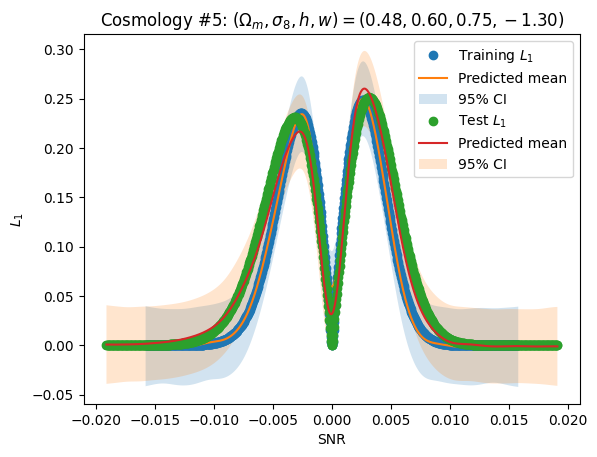

In [10]:
def predict_l1(om, sig8, h, w, snr_vals):
    """
    om, sig8, h, w: scalars
    snr_vals:       1D array of length M
    """
    snr = np.atleast_1d(snr_vals)
    M = snr.size

    # broadcast each scalar into length‑M arrays
    om_arr   = np.full(M, om)
    sig8_arr = np.full(M, sig8)
    h_arr    = np.full(M, h)
    w_arr    = np.full(M, w)

    # now column_stack to shape (M,5)
    Xp = np.column_stack([om_arr, sig8_arr, h_arr, w_arr, snr])

    # normalize
    Xp_norm = (Xp - X_mean.numpy()) / X_std.numpy()
    Xp_t    = torch.from_numpy(Xp_norm).float().to(device)

    model.eval(); likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = likelihood(model(Xp_t))

    return pred.mean.cpu().numpy(), pred.variance.cpu().numpy()


# Choose cosmology index (e.g. the first one)
idx = 2

# Extract training data for that cosmology
snr_train = kappa_array[idx]           # shape (M,)
l1_train  = l1_array[idx]            # shape (M,)

print("cosmology: ", Om_array[idx], sig8_array[idx], h_array[idx], w_array[idx])

# Run your emulator on the same SNRs
mu_pred, var_pred = predict_l1(
    Om_array[idx],
    sig8_array[idx],
    h_array[idx],
    w_array[idx],
    snr_train
)
std_pred = np.sqrt(var_pred)

# Plot
plt.figure()
# training points
plt.plot(snr_train, l1_train, 'o', label='Training $L_1$')
# GP predictive mean
plt.plot(snr_train, mu_pred,    '-', label='Predicted mean')
# 95% CI shaded region
plt.fill_between(
    snr_train,
    mu_pred - 1.96*std_pred,
    mu_pred + 1.96*std_pred,
    alpha=0.2,
    label='95% CI'
)
plt.xlabel('SNR')
plt.ylabel('$L_1$')
plt.legend()
plt.title(f'Cosmology #{idx}: ' +
          f'$(\\Omega_m,\\sigma_8,h,w)=({Om_array[idx]:.2f},' +
          f'{sig8_array[idx]:.2f},{h_array[idx]:.2f},{w_array[idx]:.2f})$')
# plt.show()

# Choose cosmology index (e.g. the first one)
idx = 5

# Extract training data for that cosmology
snr_train = kappa_array_test[idx]           # shape (M,)
l1_train  = l1_array_test[idx]            # shape (M,)

print("cosmology: ", Om_array_test[idx], sig8_array_test[idx], h_array_test[idx], w_array_test[idx])
# Run your emulator on the same SNRs
mu_pred, var_pred = predict_l1(
    Om_array_test[idx],
    sig8_array_test[idx],
    h_array_test[idx],
    w_array_test[idx],
    snr_train
)
std_pred = np.sqrt(var_pred)

# Plot
# plt.figure()
# training points
plt.plot(snr_train, l1_train, 'o', label='Test $L_1$')
# GP predictive mean
plt.plot(snr_train, mu_pred,    '-', label='Predicted mean')
# 95% CI shaded region
plt.fill_between(
    snr_train,
    mu_pred - 1.96*std_pred,
    mu_pred + 1.96*std_pred,
    alpha=0.2,
    label='95% CI'
)
plt.xlabel('SNR')
plt.ylabel('$L_1$')
plt.legend()
plt.title(f'Cosmology #{idx}: ' +
          f'$(\\Omega_m,\\sigma_8,h,w)=({Om_array[idx]:.2f},' +
          f'{sig8_array[idx]:.2f},{h_array[idx]:.2f},{w_array[idx]:.2f})$')
plt.show()

In [23]:
pip install emcee

Note: you may need to restart the kernel to use updated packages.


samples.shape = (960, 4)


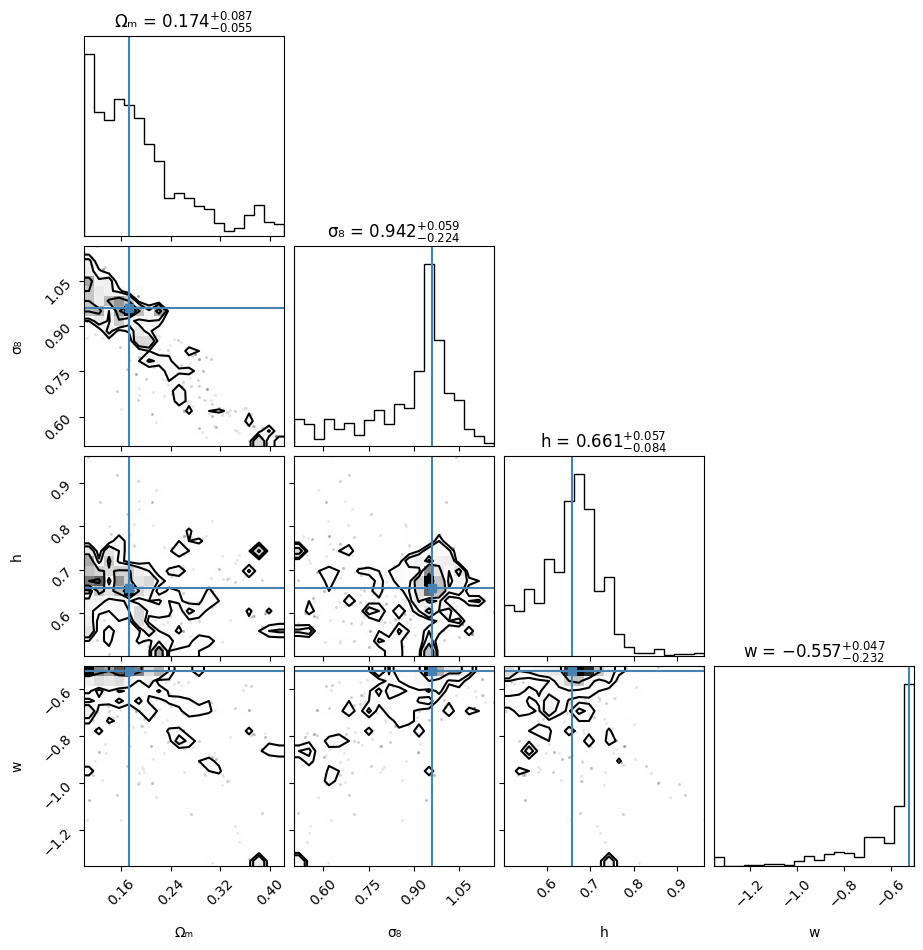

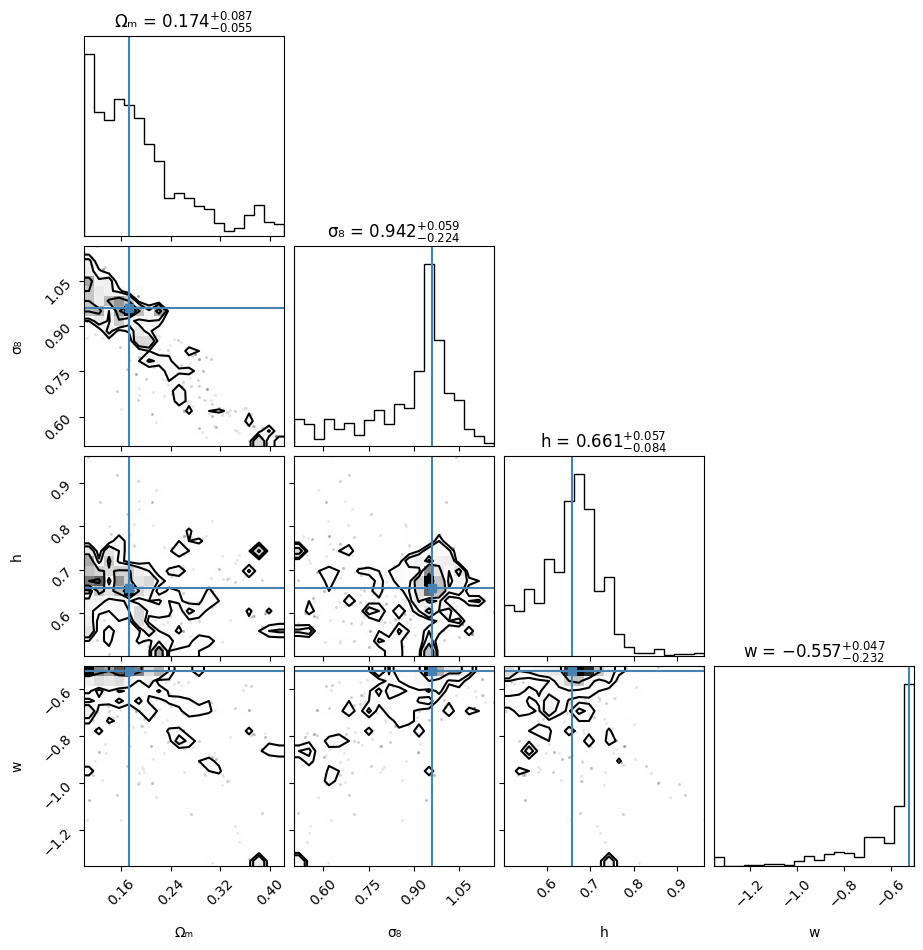

In [35]:
import numpy as np
import torch
import gpytorch
import emcee
import corner

# 0) Pick one training cosmology as “observation”
idx      = 3
snr_obs  = np.atleast_1d(snr_array[idx])     # (S,)
y_obs    = np.atleast_1d(l1_array[idx])       # (S,)
sigma_floor = 1e-3
sigma_obs = np.full_like(y_obs, sigma_floor)  # (S,)
N = len(y_obs)

# 1) Move data & model to torch/device
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()
likelihood.to(device).eval()

Xm         = X_mean.to(device)
Xs         = X_std.to(device)

y_obs_t      = torch.tensor(y_obs,   dtype=torch.float32, device=device)   # (N,)
snr_obs_t    = torch.tensor(snr_obs, dtype=torch.float32, device=device).unsqueeze(1)  # (N,1)
sigma_obs_sq = torch.tensor(sigma_obs**2, dtype=torch.float32, device=device)         # (N,)

# 2) Helper: predict on a torch tensor of shape (N,1)
def predict_l1_tensor(theta, snr_t):
    """
    theta : iterable of 4 floats (om, s8, h, w)
    snr_t : torch.Tensor of shape (N,1) on `device`
    returns: (mu_em, var_em) each a torch.Tensor of shape (N,)
    """
    om, s8, h, w = theta
    # build (N,5) input
    cosmo = torch.tensor([om, s8, h, w], dtype=torch.float32, device=device)  # (4,)
    Xc    = cosmo.unsqueeze(0).repeat(N, 1)                                   # (N,4)
    Xfull = torch.cat([Xc, snr_t], dim=1)                                     # (N,5)
    Xn    = (Xfull - Xm) / Xs                                                 # normalize
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        post = likelihood(model(Xn))
    return post.mean, post.variance                                           # each (N,)

# 3) Define log‑posterior
def log_prior(theta):
    om, s8, h, w = theta
    if 0.1 < om < 0.5 and 0.5 < s8 < 1.2 and 0.5 < h < 1.0 and -2.0 < w < -0.5:
        return 0.0
    return -np.inf

def log_likelihood(theta):
    mu_em, var_em = predict_l1_tensor(theta, snr_obs_t)  # (N,), (N,)
    var_tot       = var_em + sigma_obs_sq               # (N,)
    ll = -0.5 * torch.sum(
           torch.log(2 * torch.pi * var_tot) +
           (y_obs_t - mu_em)**2 / var_tot
         )
    return ll.item()

def log_posterior(theta):
    lp = log_prior(theta)
    return lp + log_likelihood(theta) if np.isfinite(lp) else -np.inf

# 4) Run emcee with run_mcmc
ndim, nwalkers = 4, 32
p0_center = np.array([Om_array[idx],
                      sig8_array[idx],
                      h_array[idx],
                      w_array[idx]])
p0 = p0_center + 1e-3 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
nsteps  = 50
sampler.run_mcmc(p0, nsteps)

# 5) Extract & corner‑plot
burn   = 20  # must be < nsteps
chain  = sampler.chain     # shape (nwalkers, nsteps, ndim)
posterior = chain[:, burn:, :]             # discard burn‑in
samples   = posterior.reshape(-1, ndim)    # flatten
print("samples.shape =", samples.shape)    # should be (nwalkers*(nsteps-burn), ndim)

import corner
corner.corner(
    samples,
    labels=["Ωₘ","σ₈","h","w"],
    truths=p0_center,
    show_titles=True,
    title_fmt=".3f"
)
